In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from geopy.distance import geodesic
# Set display options
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_colwidth', None)  # Show full width of column content
pd.set_option('display.max_rows', None)  # Show all rows

In this notebook we do the preproceesing of the listings, either for replication as well as for the listings that we will combine with the sentiment data later on.

In [2]:
#Read the listings from csv files
listings_amsterdam=pd.read_csv('listings_amsterdam.csv.gz')
listings_chicago=pd.read_csv('listings_chicago.csv.gz')
listings_london=pd.read_csv('listings_london.csv.gz')
listings_los_angeles=pd.read_csv('listings_los_angeles.csv.gz')
listings_new_york=pd.read_csv('listings_new_york.csv.gz')
listings_paris=pd.read_csv('listings_paris.csv.gz')
listings_melbourne=pd.read_csv('listings_melbourne.csv.gz')
listings_rome=pd.read_csv('listings_rome.csv.gz')
listings_sydney=pd.read_csv('listings_sydney.csv.gz')
listings_venice=pd.read_csv('listings_venice.csv.gz')
# Adding 'city' column to each dataframe
listings_amsterdam['city'] = 'Amsterdam'
listings_chicago['city'] = 'Chicago'
listings_london['city'] = 'London'
listings_los_angeles['city'] = 'Los Angeles'
listings_new_york['city'] = 'New York'
listings_paris['city'] = 'Paris'
listings_melbourne['city'] = 'Melbourne'
listings_rome['city'] = 'Rome'
listings_sydney['city'] = 'Sydney'
listings_venice['city'] = 'Venice'


In [3]:
listings_combined=pd.concat([listings_amsterdam,listings_chicago,listings_london,listings_los_angeles,listings_new_york,listings_paris,listings_melbourne,listings_rome,listings_sydney,listings_venice])

In [4]:
listings_combined.shape

(376028, 76)

Check for duplicates

In [5]:
#Show duplicates
listings_combined.duplicated().sum()

np.int64(0)

Originally we have a total amount of 376028 listings, in the next section we are going to check which columns contain missing values.

In [6]:
missing_values = listings_combined.isnull().sum()
missing_values = missing_values[missing_values > 0]  # Filter only columns with missing values
print(missing_values)

name                                 3
description                      13388
neighborhood_overview           182034
picture_url                         14
host_name                           20
host_since                          20
host_location                    83912
host_about                      185577
host_response_time              119095
host_response_rate              119095
host_acceptance_rate             96695
host_is_superhost                 8635
host_thumbnail_url                  20
host_picture_url                    20
host_neighbourhood              188251
host_listings_count                 20
host_total_listings_count           20
host_verifications                  20
host_has_profile_pic                20
host_identity_verified              20
neighbourhood                   182029
neighbourhood_group_cleansed    284632
bathrooms                       104317
bathrooms_text                     414
bedrooms                         33029
beds                     

In [7]:
#show the fields where first_review is missing, but price is not missing
listings_without_reviews= listings_combined[(listings_combined['first_review'].isnull()) & (listings_combined['price'].notnull())]


In [8]:
#Save as extra out-of sample test data
listings_without_reviews.to_csv('listings_without_reviews.csv',index=False)

The goal of this research is to predict the price of the listing, therefore all listings where information about the price is missing are deleted. Besides that we see that first review, last_review and review_scores_rating has the same amount of missing values, which suggest that information about reviews is missing for these listings, so we check what happen if the missing values of one of these columns, in this case first_review are also deleted.
We do this because for our research we want to see the influence of review-related features on the price, for listings with reviews.

In [9]:
listings_combined_basis = listings_combined.dropna(subset=['id', 'price','first_review'])

We check for missing values again.

In [10]:
missing_values2 = listings_combined_basis.isnull().sum()
missing_values2 = missing_values2[missing_values2 > 0]  # Filter only columns with missing values
print(missing_values2)

description                       4958
neighborhood_overview            89052
picture_url                          7
host_location                    45864
host_about                       96026
host_response_time               23950
host_response_rate               23950
host_acceptance_rate             12360
host_is_superhost                 6463
host_neighbourhood              107991
neighbourhood                    89051
neighbourhood_group_cleansed    160236
bathrooms                           60
bathrooms_text                     174
bedrooms                           165
beds                               401
calendar_updated                211317
has_availability                    54
review_scores_accuracy              29
review_scores_cleanliness           30
review_scores_checkin               38
review_scores_communication         27
review_scores_location              39
review_scores_value                 38
license                         120612
dtype: int64


In [11]:
listings_combined_basis.shape

(211317, 76)

After general preprocessing, we keep 211,317 listings.

In [12]:
listings_combined_basis.dtypes

id                                                int64
listing_url                                      object
scrape_id                                         int64
last_scraped                                     object
source                                           object
name                                             object
description                                      object
neighborhood_overview                            object
picture_url                                      object
host_id                                           int64
host_url                                         object
host_name                                        object
host_since                                       object
host_location                                    object
host_about                                       object
host_response_time                               object
host_response_rate                               object
host_acceptance_rate                            

We find that by deleting all missing values of price and first_review, the missing values of other review columns, such as last_review and review_scores_rating are also deleted. This means we keep 211.317 listings, which are a bit less than the 287.579 listings that are used in the research of (Peng et al., 2020), although if we count the columns in table 1 of (Peng et al., 2020), there are 214.457 listings used which are much closer to the 211.317 listing that we keep in our research. Besides that the code above shows that the number of listings differs between the different cities, which is also the case in the research of (Peng et al., 2020) as can be seen in table 2.


In the next step we are going to decide per column why we keep or delete it for research question 2, we also mention if a feature is mentioned in the replication and therefore relevant for Research question 1, besides that we  mention what the type of the data is:

-id, we should keep this column, because it is the listing id and therefore the key column. The type is integer.

-listing_url, we delete this columns because it has no added value for the analysis.

-scrape_id, we delete this columns because it has no added value for the analysis.

-last_scraped, we decide to keep this column, because the price depends on the day it is scraped and this is relevant information. The type is date.

-source, after some research we found that source can have 2 values, either city scrape or previous scrape, suppose that a listing is already booked, than it is not visible in the city scrape, while it is visible in previous scrape. However, the price is not visible anymore, because we already deleted the missing values of price, the source is always city scrape as shown by code above. Therefore it does not make sense to keep this column for the analysis.

-name and description,  we can use vectorizing to get interesting information out of these column. But we decide to delete it, because we already have a lot of information comparable to the name and description in the dataset. Besides that, getting useful features out of these features requires vectorizing, for example tf-idf vectorizing which will lead to a lot of columns and because there are already a lot of rows, this will be computationally hard.

-neighborhood_overview, because this column has a lot of missing values. We decide to make it binary. The overview is either available=1 or missing=0.

-picture_url, host_id, host_url and host_name are deleted, because they are not relevant for this research.

-host_since (Replication), this column is kept as in the study of (Peng, 2020) and has type date. 

-host_location and host_about also have a lot of missing values and therefore we also decide to make this column binary

-host_response_time, has 4 different options, within an hour, within a few hours , within a day or a few days or more. We use one-hot encoding to categorize these variables.

-host_response_rate and host_acceptance_rate are made numerical and kept in the study.

-host_is_superhost is made binary, where f=0 and t=1 and kept for the study.

-host_thumbnail_url and host_picture_url and host_neighborhood are deleted, because they are not relevant for the study.

-host_listings_count (Replication) is kept, but we delete host_total_listing_count as we expect it to be highly correlated with host_listing_count.

-host_verifications does not seem relevant and are deleted.

-host_has_profile_pic (Replication) and host_identity_verified are made binary, where f=0 and t=1 and are kept for the study.

-We decide to delete neighborhood_cleansed, because there are so much neighborhoods in the dataset 

-We decide to delete neighborhood_group_cleansed as it is only available in one city and therefore all the others are missing values.

-We decide to keep lantitude and longtitude and want to use the average lantitude and longtitude per city to calculate the distance to the mean_central_location. In Peng they use the is_location_exact feature, but it is not clear for me what is exactly meant with this feature.

-We keep property_type and use one-hot encoding for all neighborhoods which has between  X counts in the dataset.

-room_type (Replication) has 4 different options, Entire home/apt , Private room, Hotel room and Shared room. We use one-hot encoding to categorize these variables

-Accomodates (Replication) is kept as integer.

-Bathrooms (Replication), bedrooms(Replication) are kept as integers.

-Beds is deleted as it highly correlates with the accomodates variable.

-Bathrooms_text is deleted as it does not add value to the analysis.

-We decide to use one-hot encoding for the amenities, and design features for the amenities which are counted between 10 and 90 percent of the time.

-price is going to be adjusted to be an integer and is going to be the test variable of our dataset.

-We choose to use minimum_nights (Replication) and maximum_nights and delete all related variables such as minimum_minimum_nights, maximum_minimum_nights, minimum_maximum_nights, maximum_maximum_nights, minimum_nights_avg_ntm and maximum_nights_avg_ntm.

-We choose to delete calendar_updated as it has only missing values.

-We choose to delete has_availability, because this is true and should be true for (almost) all listings and therefore this feature does not add value to the analysis.

-We choose to keep avialability_365 (Replication) as an integer and therefore delete availability_30, availability_60, availability_90 as features. Because keeping all these columns would lead to overlapping information.

-We delete calendar_last_scraped, because it is almost the same as the last_scraped column

-We delete license, because it is not relevant for the study

-We decide to keep instant_bookable and make it binary, where f=0 and t=1.

-calculated_host_listings_count, calculated_host_listings_count_entire_homes, calculated_host_listings_count_private_rooms and calculated_host_listings_count_shared_rooms are deleted, because they will have no added value for the study

-City is categorized by using one-hot encoding.

-All other features/columns are related to the reviews or the review scores and therefore we take them out of scope of the listing study

First we are going to use the same features as in the research of Peng, compared to this paper, three features that are used in the analysis of Peng are deleted from the data source. Those 3 are 'is_location_exact', 'guest_included' and 'cancellation_policy'. We make the assumption that those three features do not have added value to the predictions. Next to that, the paper uses the feature host_since, which has the type date. We make the assumption to take the difference between the 'last_scraped' and 'host_since' dates, and call this feature host_duration. Because there has to be a numerical value, otherwise the feature can not be used in the analysis.

In [13]:
#Replication
replicated_features=['id','last_scraped', 'host_since', 'price', 'host_has_profile_pic', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'minimum_nights', 'availability_365', 'number_of_reviews', 'reviews_per_month']

In [14]:
listings_combined2=listings_combined_basis

In [15]:
replication=listings_combined2[replicated_features]

In [16]:
missing_values3 = replication.isnull().sum()
missing_values3 = missing_values3[missing_values3 > 0]  # Filter only columns with missing values
print(missing_values3)

bathrooms     60
bedrooms     165
dtype: int64


As we can see there are only two columns left that contain missing values, like in the study of 'Peng' we impute these missing values by the mean.

In [17]:
# Impute missing values in bathrooms and bedrooms columns with the mean
replication['bathrooms'] = replication['bathrooms'].fillna(replication['bathrooms'].mean())
replication['bedrooms'] = replication['bedrooms'].fillna(replication['bedrooms'].mean())

# Convert room_type to a categorical variable with numerical values if it exists
if 'room_type' in replication.columns:
    replication['room_type'] = replication['room_type'].astype('category').cat.codes

# Convert date columns to datetime and calculate host duration
replication['last_scraped'] = pd.to_datetime(listings_combined2['last_scraped'])
replication['host_since'] = pd.to_datetime(listings_combined2['host_since'])
replication['host_duration'] = (replication['last_scraped'] - replication['host_since']).dt.days
replication.drop(columns=['last_scraped', 'host_since'], inplace=True)

# Convert price to float
replication['price'] = replication['price'].replace('[\$,]', '', regex=True).astype(float)

# Replace 't'/'f' with 1/0 for host_has_profile_pic
replication['host_has_profile_pic'] = replication['host_has_profile_pic'].replace({'t': 1, 'f': 0})

# Apply lambda function to convert True/False to 1/0
replication = replication.applymap(lambda x: 1 if x is True else (0 if x is False else x))

# Display the first few rows of the dataframe
replication.head()



<>:16: SyntaxWarning: invalid escape sequence '\$'
<>:16: SyntaxWarning: invalid escape sequence '\$'
C:\Users\PC\AppData\Local\Temp\ipykernel_15544\4051636652.py:16: SyntaxWarning: invalid escape sequence '\$'
  replication['price'] = replication['price'].replace('[\$,]', '', regex=True).astype(float)
C:\Users\PC\AppData\Local\Temp\ipykernel_15544\4051636652.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  replication['bathrooms'] = replication['bathrooms'].fillna(replication['bathrooms'].mean())
C:\Users\PC\AppData\Local\Temp\ipykernel_15544\4051636652.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

,id,price,host_has_profile_pic,room_type,accommodates,bathrooms,bedrooms,minimum_nights,availability_365,number_of_reviews,reviews_per_month,host_duration
10,888038298563003925,269.0,1,2,3,1.0,1.0,1,323,8,0.37,1750
31,50666229,254.0,1,2,4,1.0,2.0,4,275,165,4.37,1214
32,933523,203.0,1,2,4,1.5,2.0,3,10,140,1.11,4225
34,656222143862971193,599.0,1,0,2,1.0,1.0,3,247,14,0.56,3332
36,20259345,109.0,1,2,2,1.5,1.0,1,40,712,9.06,3631


We do the same preprocessing steps as in the replication and choose to remove the listings with a price below 0 or above 500.

In [18]:
# Eliminate data of houses with prices greater than $500 or less than or equal to $0
replication = replication[(replication['price'] > 0) & (replication['price'] <= 500)]

# Apply logarithmic transformation to the price column
replication['price'] = np.log1p(replication['price'])

replication.shape

(200361, 12)

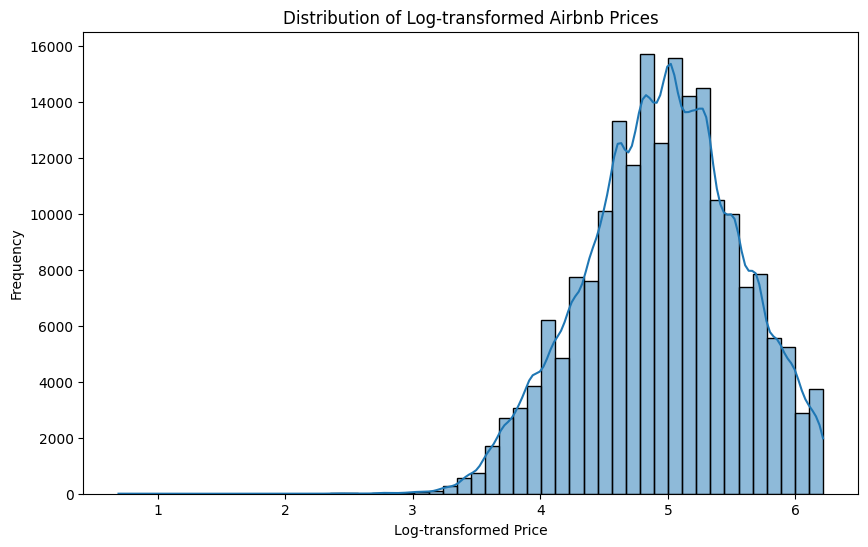

In [19]:
# Visualize the distribution of the log-transformed price
# Visualize price distribution to analyze outliers
plt.figure(figsize=(10, 6))
sns.histplot(replication['price'], bins=50, kde=True)
plt.xlabel('Log-transformed Price')
plt.ylabel('Frequency')
plt.title('Distribution of Log-transformed Airbnb Prices')
plt.show()


In [20]:
replication.to_csv('replication.csv', index=False)

Now I continue experimenting with my own design feature sets. In the first approach we test one-hot encoding.

In [21]:
#Show the missing values of listings_combined_basis
missing_values2 = listings_combined_basis.isnull().sum()
#Show missing values if there are any
missing_values2 = missing_values2[missing_values2 > 0]  # Filter only columns with missing values
print(missing_values2)

description                       4958
neighborhood_overview            89052
picture_url                          7
host_location                    45864
host_about                       96026
host_response_time               23950
host_response_rate               23950
host_acceptance_rate             12360
host_is_superhost                 6463
host_neighbourhood              107991
neighbourhood                    89051
neighbourhood_group_cleansed    160236
bathrooms                           60
bathrooms_text                     174
bedrooms                           165
beds                               401
calendar_updated                211317
has_availability                    54
review_scores_accuracy              29
review_scores_cleanliness           30
review_scores_checkin               38
review_scores_communication         27
review_scores_location              39
review_scores_value                 38
license                         120612
dtype: int64


There is one formula that we have designed to calculate the distance to the center

In [22]:
# Calculate distance to the city center for each listing
def calculate_distance(row):
    return geodesic((row['latitude'], row['longitude']), (row['mean_latitude'], row['mean_longitude'])).km

In [23]:
from sklearn.preprocessing import OrdinalEncoder

In [24]:
import pandas as pd
import json
from sklearn.preprocessing import OrdinalEncoder
from collections import Counter

# Assuming listings_combined_basis is already defined
columns_to_keep = [
    'id', 'last_scraped', 'neighborhood_overview', 
    'host_since', 'host_location', 'host_about', 'host_response_time', 
    'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 
    'host_listings_count', 'host_has_profile_pic', 
    'host_identity_verified', 'latitude', 'longitude', 
    'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
    'amenities', 'price', 'minimum_nights', 'maximum_nights', 'availability_365', 
    'instant_bookable', 'city'
]

# Filter the DataFrame to keep only relevant columns
listings_combined3 = listings_combined_basis[columns_to_keep]

# Convert date columns to datetime
listings_combined3['last_scraped'] = pd.to_datetime(listings_combined3['last_scraped'])
listings_combined3['host_since'] = pd.to_datetime(listings_combined3['host_since'])
listings_combined3['host_duration'] = (listings_combined3['last_scraped'] - listings_combined3['host_since']).dt.days

# Convert binary features with missing values to numerical
binary_columns = ['neighborhood_overview', 'host_location', 'host_about']
for col in binary_columns:
    listings_combined3[col] = listings_combined3[col].notna().astype(int)

# Convert other binary features
other_binaries = ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'instant_bookable']
for col in other_binaries:
    listings_combined3[col] = listings_combined3[col].map({'f': 0, 't': 1}).fillna(0).astype(int)

# Process amenities
listings_combined3['amenities'] = listings_combined3['amenities'].apply(lambda x: json.loads(x) if pd.notna(x) else [])
all_amenities = [amenity for amenities_list in listings_combined3['amenities'] for amenity in amenities_list]
amenities_counts = Counter(all_amenities)
num_listings = len(listings_combined3)
common_amenities = [amenity for amenity, count in amenities_counts.items() if 0.1 * num_listings <= count <= 0.9 * num_listings]

# Create binary columns for each common amenity
for amenity in common_amenities:
    listings_combined3[amenity] = listings_combined3['amenities'].apply(lambda x: 1 if amenity in x else 0)

# Drop the original amenities column
listings_combined3.drop(columns=['amenities'], inplace=True)

# Handle property_type
property_type_counts = listings_combined3['property_type'].value_counts(normalize=True)
valid_property_types = property_type_counts[property_type_counts >= 0.01].index
listings_combined3['property_type'] = listings_combined3['property_type'].apply(lambda x: x if x in valid_property_types else 'Other')

# Convert percentages to numerical
listings_combined3['host_response_rate'] = listings_combined3['host_response_rate'].str.replace('%', '').astype(float) / 100
listings_combined3['host_acceptance_rate'] = listings_combined3['host_acceptance_rate'].str.replace('%', '').astype(float) / 100
listings_combined3['host_response_rate'].fillna(listings_combined3['host_response_rate'].mean(), inplace=True)
listings_combined3['host_acceptance_rate'].fillna(listings_combined3['host_acceptance_rate'].mean(), inplace=True)

# Calculate distance to city center
mean_coordinates = listings_combined3.groupby('city')[['latitude', 'longitude']].mean().rename(columns={'latitude': 'mean_latitude', 'longitude': 'mean_longitude'})
listings_combined3 = listings_combined3.merge(mean_coordinates, on='city')
listings_combined3['distance_to_center'] = listings_combined3.apply(calculate_distance, axis=1)
listings_combined3.drop(columns=['mean_latitude', 'mean_longitude'], inplace=True)

# Handle missing values for host_response_time
listings_combined3['host_response_time_missing'] = listings_combined3['host_response_time'].isnull().astype(int)
listings_combined3['host_response_time'].fillna('Missing', inplace=True)

# Apply Ordinal Encoding
ordinal_encoder = OrdinalEncoder()
categorical_columns = ['host_response_time', 'property_type', 'room_type', 'city']
listings_combined3[categorical_columns] = listings_combined3[categorical_columns].astype(str)
listings_combined3[categorical_columns] = ordinal_encoder.fit_transform(listings_combined3[categorical_columns])

# Drop unnecessary columns
listings_combined3.drop(columns=['host_response_time_missing', 'host_since', 'last_scraped'], inplace=True)

# Convert price to numerical
listings_combined3['price'] = listings_combined3['price'].replace('[\$,]', '', regex=True).astype(float)

# Fill missing values for bathrooms, bedrooms
median_fill_columns = ['bathrooms', 'bedrooms']
for column in median_fill_columns:
    listings_combined3[column].fillna(listings_combined3[column].median(), inplace=True)

# Display the cleaned DataFrame
print(listings_combined3.head())



<>:81: SyntaxWarning: invalid escape sequence '\$'
<>:81: SyntaxWarning: invalid escape sequence '\$'
C:\Users\PC\AppData\Local\Temp\ipykernel_15544\1166594977.py:81: SyntaxWarning: invalid escape sequence '\$'
  listings_combined3['price'] = listings_combined3['price'].replace('[\$,]', '', regex=True).astype(float)
C:\Users\PC\AppData\Local\Temp\ipykernel_15544\1166594977.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings_combined3['last_scraped'] = pd.to_datetime(listings_combined3['last_scraped'])
C:\Users\PC\AppData\Local\Temp\ipykernel_15544\1166594977.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

                   id  neighborhood_overview  host_location  host_about  \
0  888038298563003925                      0              0           0   
1            50666229                      1              1           1   
2              933523                      1              1           1   
3  656222143862971193                      0              1           1   
4            20259345                      1              1           1   

   host_response_time  host_response_rate  host_acceptance_rate  \
0                 4.0                 1.0                  1.00   
1                 4.0                 1.0                  1.00   
2                 4.0                 1.0                  0.97   
3                 3.0                 1.0                  1.00   
4                 4.0                 1.0                  1.00   

   host_is_superhost  host_listings_count  host_has_profile_pic  \
0                  0                  9.0                     1   
1           

C:\Users\PC\AppData\Local\Temp\ipykernel_15544\1166594977.py:86: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  listings_combined3[column].fillna(listings_combined3[column].median(), inplace=True)
C:\Users\PC\AppData\Local\Temp\ipykernel_15544\1166594977.py:86: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values al

In [25]:
#Show property type value counts
listings_combined3['property_type'].value_counts()


property_type
4.0     106585
3.0      20810
0.0      17492
7.0      16992
11.0     16768
10.0     14767
9.0       4597
2.0       3192
5.0       2926
8.0       2598
6.0       2351
1.0       2239
Name: count, dtype: int64

We check which city belongs to which number, because this is needed later in the research

In [26]:
# Fit the OrdinalEncoder to the 'city' column
ordinal_encoder = OrdinalEncoder()
encoded_cities = ordinal_encoder.fit_transform(listings_combined_basis[['city']])

# Extract the mapping
city_mapping = {index: city for index, city in enumerate(ordinal_encoder.categories_[0])}

# Display the mapping
for encoded_value, city in city_mapping.items():
    print(f"{encoded_value}: {city}")



0: Amsterdam
1: Chicago
2: London
3: Los Angeles
4: Melbourne
5: New York
6: Paris
7: Rome
8: Sydney
9: Venice


We use the code below, to check all variables for outliers. We checked all numerical variables, for the binaries we already assume there are no outliers, because of the way these binaries are designed. We only change the outliers if we believe they are unrealistic, for only one we find is the one below which has 50 bedrooms and bathrooms, while the accommodation only accomodates 4 persons.

In [27]:
listings_combined3['bathrooms'].describe()

count    211317.000000
mean          1.334616
std           0.713213
min           0.000000
25%           1.000000
50%           1.000000
75%           1.500000
max          50.000000
Name: bathrooms, dtype: float64

In [28]:
listings_combined3['distance_to_center'].describe()

count    211317.000000
mean          7.812755
std           8.945028
min           0.014691
25%           2.675778
50%           4.746610
75%           9.393732
max          88.468325
Name: distance_to_center, dtype: float64

In [29]:
#Check the observations where bathrooms is above 30
bathrooms_check=listings_combined3[listings_combined3['bathrooms'] > 30]
#impute the number of bathrooms and bedrooms from the listings_combined2 by their respecitve means
listings_combined3['bathrooms'] = listings_combined3['bathrooms'].replace(50, listings_combined3['bathrooms'].mean())
listings_combined3['bedrooms'] = listings_combined3['bedrooms'].replace(50, listings_combined3['bedrooms'].mean())


In [30]:
#Check correlation between beds and accommodates
listings_combined3[['beds', 'accommodates']].corr()

,beds,accommodates
beds,1.000000,0.802564
accommodates,0.802564,1.000000


In [31]:
listings_combined3.drop(columns=['beds'], inplace=True)

As expected we see a high correlation between beds and accommodates, so we decide to delete beds from the model.

At this moment, almost all columns are numerical, unless some columns of which we don't know what to do with at this moment. In the following step comparable to the study of (Peng et al., 2020), we will impute the missing values of all numeric columns by using the attribute mean, which is the majority in case of a binary column. Secondly Peng removes outliers by eliminating data of houses with prices greater than 500 or prices lower than 0. In my opinion, deleting the prices lower than 0, makes sense but deleting prices greater than 500 not. However 500 may be expensive for a night, it seems a true value, however if the price rise above 40.000 which is the case in some examples as shown by the boxplot above, it must be illegal values. Lastly, we apply a logarithmic transformation to the price column as also done in the replication.

In [32]:
# Eliminate data of houses with prices greater than $40000 or less than or equal to $0
listings_combined3 = listings_combined3[(listings_combined3['price'] > 0) & (listings_combined3['price'] <= 40000)]

#Separate preprocessing to compare against the replication
listings_combined4=listings_combined3[(listings_combined3['price'] > 0) & (listings_combined3['price'] <= 500)]

# Impute missing values with the mean for numerical columns
for col in listings_combined3.select_dtypes(include=['float64', 'int64']).columns:
    listings_combined3[col].fillna(listings_combined3[col].mean(), inplace=True)

# Apply logarithmic transformation to the price column
listings_combined3['price'] = np.log1p(listings_combined3['price'])
listings_combined4['price'] = np.log1p(listings_combined4['price'])

listings_combined3.shape
listings_combined4.shape

C:\Users\PC\AppData\Local\Temp\ipykernel_15544\3239450886.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  listings_combined3[col].fillna(listings_combined3[col].mean(), inplace=True)
C:\Users\PC\AppData\Local\Temp\ipykernel_15544\3239450886.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

(200361, 98)

We do a outlier analysis, to see if this worked out

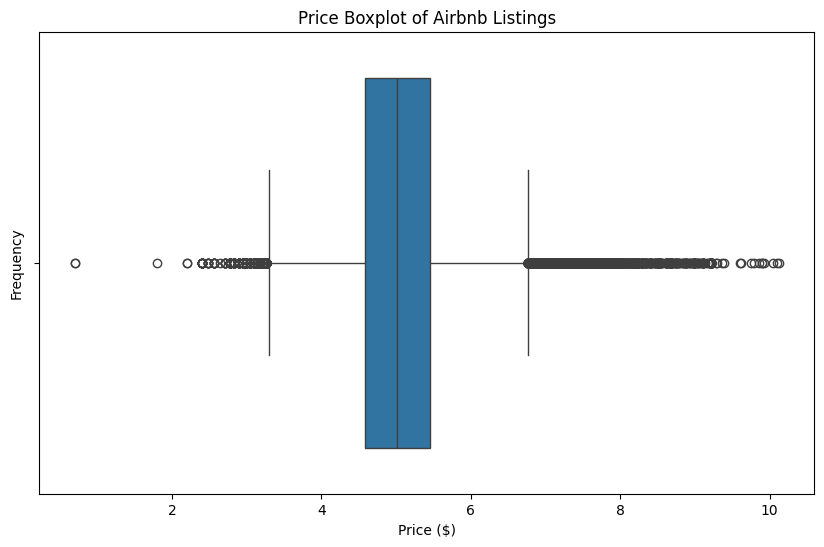

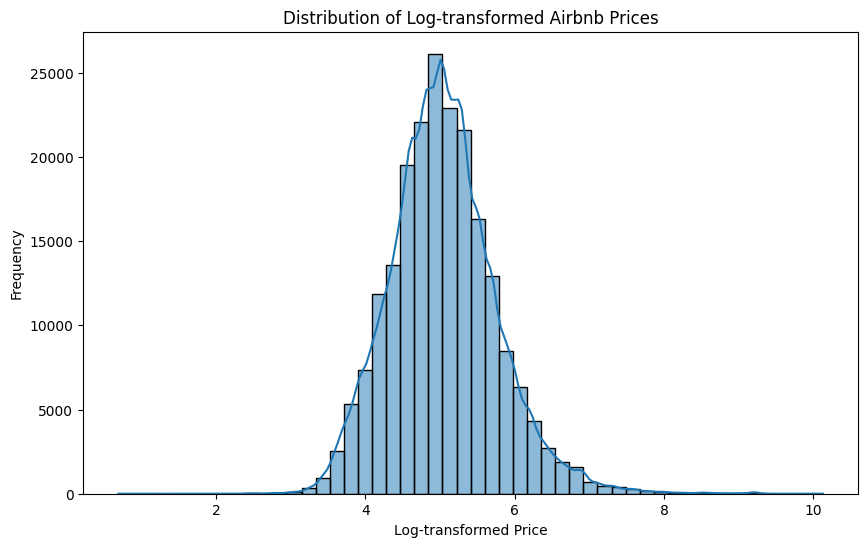

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
# Visualize price distribution using a boxplot to analyze outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x=listings_combined3['price'])
plt.xlabel('Price ($)')
plt.ylabel('Frequency')
plt.title('Price Boxplot of Airbnb Listings')
plt.show()
# Visualize price distribution using a histogram to analyze outliers
plt.figure(figsize=(10, 6))
sns.histplot(listings_combined3['price'], bins=50, kde=True)
plt.xlabel('Log-transformed Price')
plt.ylabel('Frequency')
plt.title('Distribution of Log-transformed Airbnb Prices')
plt.show()


If we look at the distribution, we see that there are stil outliers, we decide to adjust the distribution and only keep columns where the log-transformed price is between 2 and 8.

In [36]:
#delete columns where log price below 2 or above 8
listings_combined3 = listings_combined3[(listings_combined3['price'] > 2) & (listings_combined3['price'] < 8)]
listings_combined3.shape

(210937, 98)

In [37]:
listings_combined3.columns

Index(['id', 'neighborhood_overview', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_listings_count', 'host_has_profile_pic',
       'host_identity_verified', 'latitude', 'longitude', 'property_type',
       'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'price',
       'minimum_nights', 'maximum_nights', 'availability_365',
       'instant_bookable', 'city', 'host_duration', 'Body soap',
       'Coffee maker', 'Carbon monoxide alarm', 'Smoke alarm',
       'Extra pillows and blankets', 'Luggage dropoff allowed', 'Hair dryer',
       'Elevator', 'Wifi', 'Cleaning available during stay',
       'Air conditioning', 'Hangers', 'Essentials', 'Heating', 'TV',
       'First aid kit', 'Shampoo', 'Fire extinguisher', 'Bed linens',
       'Dishes and silverware', 'Toaster', 'Shower gel', 'Coffee',
       'Portable fans', 'Dedicated workspace', 'Cooking basics', 'Hot water',
       'Iron', 'Cleani

In [38]:
listings_combined3.to_csv('listings_features_ordinal_encoded.csv', index=False)

In [33]:
listings_combined4.to_csv('listings_features_ordinal_encoded_replication.csv', index=False)

In [34]:
listings_combined4.shape

(200361, 98)

So the final shape of this one-hot encoded feature set is (210937,98)

We now saved a file for the listing reviews and the next step is to do the same for the review features, we first collect and select all relevant features related to reviews that are in this listing dataset and nextly we add the LDA related sentiment scores that are extracted from the reviews dataset. We do this in a separate notebook.

In [40]:
#From listings_combined_basis, we keep the ID for merging purpose
review_data = listings_combined_basis[['id', 'last_scraped','number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
    'first_review', 'last_review', 'review_scores_rating',
    'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
    'review_scores_communication', 'review_scores_location', 'review_scores_value',
    'reviews_per_month']]

In [41]:
#Change the rows of the review data to listings_combined3 to have the same subset of listings that are preprocessed similarly on the price variable.
review_data = review_data[review_data['id'].isin(listings_combined3['id'])]


In [42]:
review_data.shape

(210937, 15)

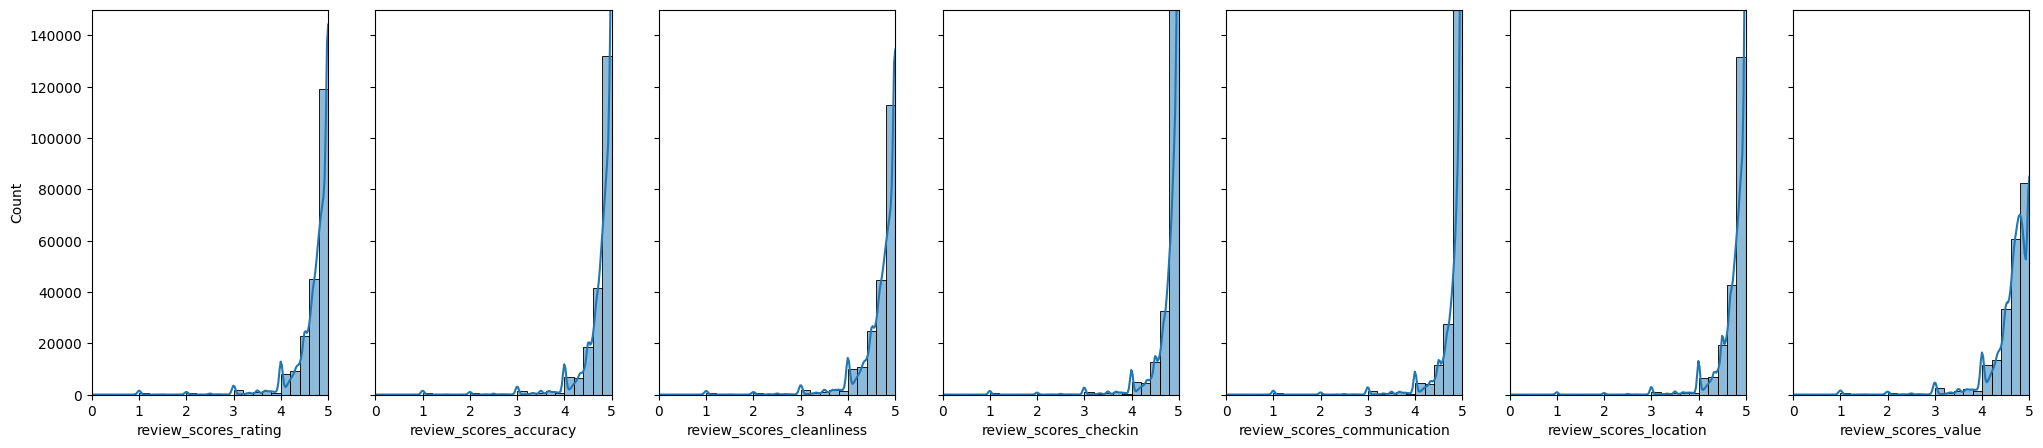

In [41]:
#Show a plot with the distribution of all the review score related variables to see how correlated they are, make sure to make seven
#subplots in one row, use the same scale for all figures, make sure that all the 7 figures fit in the same plot
fig, axes = plt.subplots(1, 7, figsize=(25, 5), sharex=True, sharey=True)
sns.histplot(review_data['review_scores_rating'], bins=25, kde=True, ax=axes[0])
sns.histplot(review_data['review_scores_accuracy'], bins=25, kde=True, ax=axes[1])
sns.histplot(review_data['review_scores_cleanliness'], bins=25, kde=True, ax=axes[2])
sns.histplot(review_data['review_scores_checkin'], bins=25, kde=True, ax=axes[3])
sns.histplot(review_data['review_scores_communication'], bins=25, kde=True, ax=axes[4])
sns.histplot(review_data['review_scores_location'], bins=25, kde=True, ax=axes[5])
sns.histplot(review_data['review_scores_value'], bins=25, kde=True, ax=axes[6])
#make sure all figures have the same x and y axis values
plt.xlim(0, 5)
plt.ylim(0, 150000)
plt.show()










In [42]:
#Show a correlation matrix of the review scores
review_scores = review_data[['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
    'review_scores_communication', 'review_scores_location', 'review_scores_value']]
correlation_matrix = review_scores.corr()
correlation_matrix



,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
review_scores_rating,1.000000,0.858738,0.793234,0.710198,0.773867,0.588991,0.852376
review_scores_accuracy,0.858738,1.000000,0.746026,0.671729,0.724910,0.574507,0.811345
review_scores_cleanliness,0.793234,0.746026,1.000000,0.587542,0.620854,0.503688,0.736032
review_scores_checkin,0.710198,0.671729,0.587542,1.000000,0.733029,0.509461,0.651469
review_scores_communication,0.773867,0.724910,0.620854,0.733029,1.000000,0.514799,0.712487
review_scores_location,0.588991,0.574507,0.503688,0.509461,0.514799,1.000000,0.581153
review_scores_value,0.852376,0.811345,0.736032,0.651469,0.712487,0.581153,1.000000


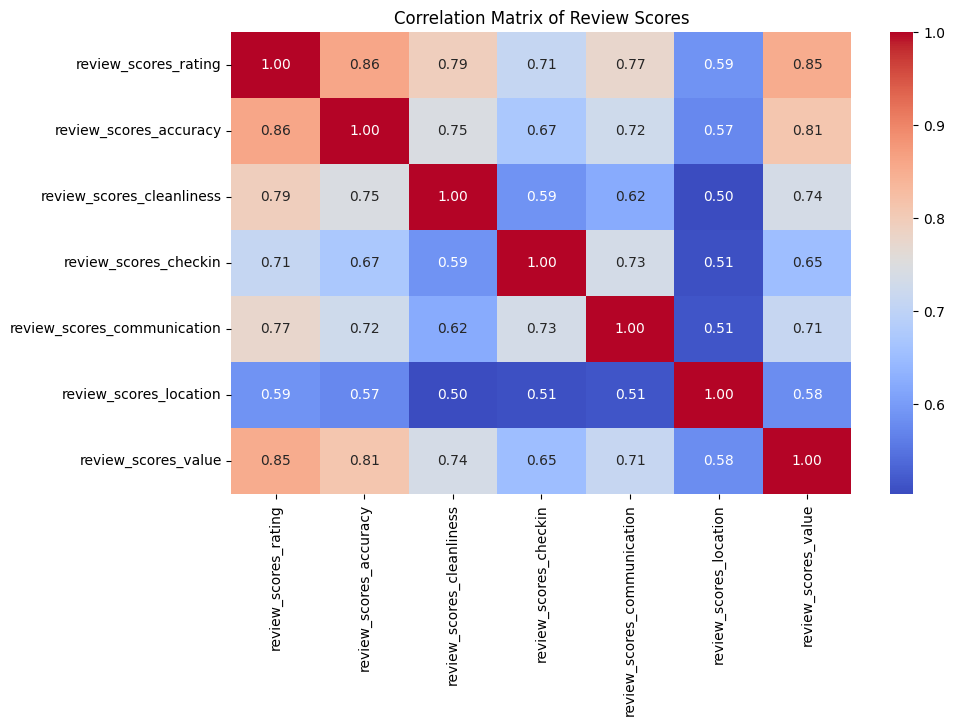

In [43]:
#Show a graph of the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Review Scores')
plt.show()

In [44]:
#Show the correlatioins of number_of_reviews, number_of_reviews_ltm, number_of_reviews_l30d, reviews_per_month
reviews_amount = review_data[['number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'reviews_per_month']]
correlation_matrix2 = reviews_amount.corr()
correlation_matrix2

,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,reviews_per_month
number_of_reviews,1.000000,0.657443,0.397215,0.546776
number_of_reviews_ltm,0.657443,1.000000,0.690192,0.810396
number_of_reviews_l30d,0.397215,0.690192,1.000000,0.729942
reviews_per_month,0.546776,0.810396,0.729942,1.000000


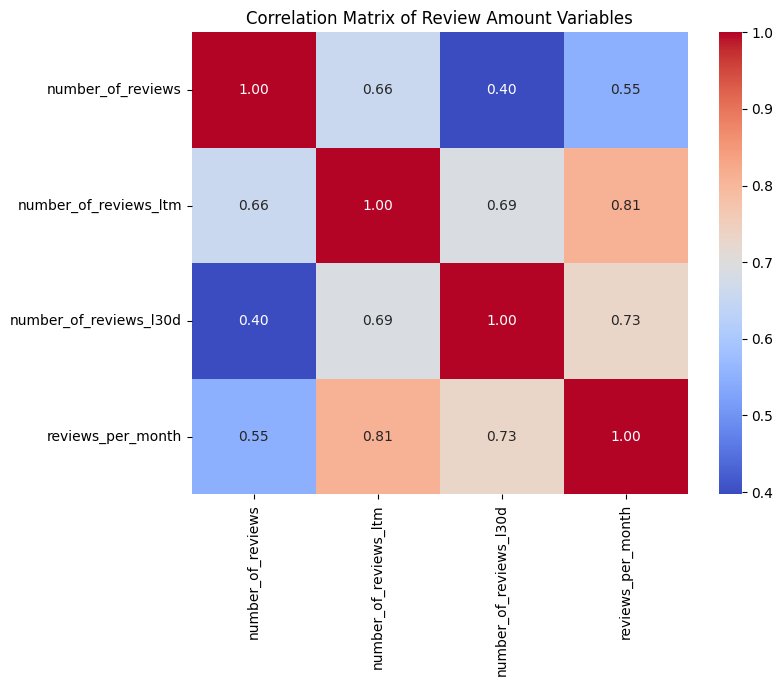

In [45]:
#Show a graphical presentation of this correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix2, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Review Amount Variables')
plt.show()

We see above the distributions of all review_related data, as we can see review_scores_rating is an average of all the other six review related scores. We choose to keep all six scores, but we decide to delete the review_scores_rating as it correlates too much with the other six review_scores. We believe that the features that relate to the number of reviews will also correlate with each other and therefore we decide to keep only the number_of _reviews and number_of_reviews_l30d

We decide to add all the following features:  'number_of_reviews',
       'first_review','last_review', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'number_of_reviews_ltm'.

-Because first_review and last_reviews are dates and thus objects we decide to count the difference in days between the last_scraped date and those two columns and add this as a feature to the model. We decide to fill the missing values with the median to remove the effect of outliers.

In [43]:
#Drop review_scores_rating, 'number_of_reviews_ltm', 'number_of_reviews_l30d'
review_data.drop(columns=['review_scores_rating', 'number_of_reviews_ltm', 'reviews_per_month'], inplace=True)


In [44]:
#Show missing values
missing_values = review_data.isnull().sum()
missing_values = missing_values[missing_values > 0]  # Filter only columns with missing values
print(missing_values)

review_scores_accuracy         23
review_scores_cleanliness      24
review_scores_checkin          32
review_scores_communication    21
review_scores_location         33
review_scores_value            32
dtype: int64


In [45]:
import pandas as pd

# Assuming listings_combined and review_data are already defined
review_data = review_data.reset_index(drop=True)

# Step 4: Add columns from columns to add to review_data
review_data = review_data

# Convert date columns to datetime
review_data['first_review'] = pd.to_datetime(review_data['first_review'])
review_data['last_review'] = pd.to_datetime(review_data['last_review'])
review_data['last_scraped'] = pd.to_datetime(review_data['last_scraped'])

# Create new columns for the number of days between first and last reviews
review_data['days_between_first_review'] = (review_data['last_scraped'] - review_data['first_review']).dt.days
review_data['days_since_last_review'] = (review_data['last_scraped'] - review_data['last_review']).dt.days

# Step 5: Impute missing values 
review_data['number_of_reviews']
review_data['review_scores_accuracy'].fillna(review_data['review_scores_accuracy'].median(), inplace=True)
review_data['review_scores_cleanliness'].fillna(review_data['review_scores_cleanliness'].median(), inplace=True)
review_data['review_scores_checkin'].fillna(review_data['review_scores_checkin'].median(), inplace=True)
review_data['review_scores_communication'].fillna(review_data['review_scores_communication'].median(), inplace=True)
review_data['review_scores_location'].fillna(review_data['review_scores_location'].median(), inplace=True)
review_data['review_scores_value'].fillna(review_data['review_scores_value'].median(), inplace=True)
review_data['days_between_first_review']
review_data['days_since_last_review']

# Drop the date columns if no longer needed
review_data.drop(columns=['first_review', 'last_review', 'last_scraped'], inplace=True)

# Print out the head of review_data to check the results
print(review_data.head())



                   id  number_of_reviews  number_of_reviews_l30d  \
0  888038298563003925                  8                       0   
1            50666229                165                       6   
2              933523                140                       2   
3  656222143862971193                 14                       0   
4            20259345                712                       7   

   review_scores_accuracy  review_scores_cleanliness  review_scores_checkin  \
0                    5.00                       4.88                   4.75   
1                    4.87                       4.85                   4.99   
2                    4.84                       4.93                   4.97   
3                    4.86                       4.86                   5.00   
4                    4.93                       4.84                   4.92   

   review_scores_communication  review_scores_location  review_scores_value  \
0                         4.50       

C:\Users\PC\AppData\Local\Temp\ipykernel_16372\2923999407.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  review_data['review_scores_accuracy'].fillna(review_data['review_scores_accuracy'].median(), inplace=True)
C:\Users\PC\AppData\Local\Temp\ipykernel_16372\2923999407.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we

In [46]:
review_data.shape

(210937, 11)

So the final shape of this review feature set is (210937,11)

In [47]:
#save review_data to a csv file
review_data.to_csv('listings_features_reviews.csv', index=False)